In [ ]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
import copy
import os.path
import pdb
import re
from run_split import SplitMnistGenerator
from alg.cla_models_multihead import MFVI_NN, Vanilla_NN
from alg.HIBP_BNN_multihead import HIBP_BNN
from alg.IBP_BNN_multihead import IBP_BNN
from hibp_weight_pruning import prune_weights, MnistGenerator
from alg.utils import get_scores, concatenate_results
from alg.vcl import run_vcl
from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Weight pruning

In [ ]:
hidden_size = [200, 200]
batch_size = 128
no_epochs = 100
runs = 1
seeds = [1,2,3,4,5]
np.random.seed(1)
xs = np.append(0.1 * np.array(range(10)), [0.95, 0.96, 0.97, 0.98, 0.99, 0.992, 0.995, 0.997, 0.999])
ya_ibp_all = np.zeros((runs, len(xs)))
yb_ibp_all = np.zeros((runs, len(xs)))

for i in range(runs):
    tf.set_random_seed(seeds[i])
    coreset_size = 0
    data_gen = MnistGenerator(val=False)
    single_head=False
    in_dim, out_dim = data_gen.get_dims()
    x_testsets, y_testsets = [], []
    task_id=0

    tf.reset_default_graph()  
    x_train, y_train, x_test, y_test = data_gen.task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size

    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 10, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    model = HIBP_BNN(alphas=[1.]*len(hidden_size), 
                     input_size=in_dim, 
                     hidden_size=hidden_size, 
                     output_size=out_dim, 
                     training_size=x_train.shape[0], 
                     no_pred_samples=10,
                     num_ibp_samples=10, prev_means=mf_weights, 
                     prev_log_variances=mf_variances, 
                     prev_betas=mf_betas,
                     learning_rate=0.001, learning_rate_decay=0.87,
                     prior_mean=0.0, prior_var=0.7,
                     alpha0=5.0, beta0=1.0,
                     lambda_1=5.0, lambda_2=1.0,
                     tensorboard_dir='logs_wp',
                     name='hibp_anneal',
                     use_local_reparam=True, implicit_beta=True,
                     hard_Z=False, cutoff=0.1)
    model.create_model()
    #model.restore(os.path.join("logs_wp", 'graph_{0}'.format('hibp_mnist_hZ_n_ibp_samples100')))
    model.train(x_train, y_train, head, no_epochs, bsize)
    acc, neg_elbo = model.prediction_acc(x_test, y_test, bsize, head)
    print(acc)
    print(neg_elbo)

#     xs, ya_ibp, yb_ibp  = prune_weights(model, x_test, y_test, bsize, head, xs)
#     ya_ibp_all[i, :] = ya_ibp
#     yb_ibp_all[i, :] = yb_ibp

    model.close_session()

In [ ]:
with open('results/weight_pruning_ibp_new_xs.pkl', 'wb') as input_file:
    pickle.dump({'xs': xs,
                 'ya_ibp': ya_ibp_all,
                 'yb_ibp': yb_ibp_all}, input_file)

# No IBP

In [ ]:
hidden_size = [200, 200]
batch_size = 128
no_epochs = 100
runs = 1
seeds = [10,11,12,13,14]
xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))
ya_all = np.zeros((runs, len(xs)))
yb_all = np.zeros((runs, len(xs)))

for i in range(runs):
    tf.set_random_seed(seeds[i])
    np.random.seed(1)
    coreset_size = 0
    data_gen = MnistGenerator()
    single_head=False
    in_dim, out_dim = data_gen.get_dims()
    task_id=0

    tf.reset_default_graph()  
    x_train, y_train, x_test, y_test = data_gen.task()

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size

    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 100, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        ml_model.close_session()

    # Train on non-coreset data
    model = MFVI_NN(in_dim, hidden_size, out_dim, x_train.shape[0], prev_means=mf_weights, 
                    prev_log_variances=mf_variances, 
                    learning_rate=0.001, learning_rate_decay=0.87,
                    prior_mean=0.0, prior_var=0.8,
                    tensorboard_dir='logs_wp',
                    name='mfvi_wp_mnist_newp_run{0}'.format(i),
                    use_local_reparam=True)
    #model.restore(os.path.join("logs_wp", 'graph_{0}'.format('hibp_wp_mnist_new_run{0}'.format(i))))
    model.train(x_train, y_train, head, no_epochs, bsize)

    xs, ya_ibp, yb_ibp  = prune_weights(model, x_test, y_test, bsize, head, xs)
    
    ya_all[i, :] = ya
    yb_all[i, :] = yb

    mf_model.close_session()

In [ ]:
_ibp_ya_mean = np.mean(ya_ibp_all, axis=0)
_ibp_ya_std = np.std(ya_ibp_all, axis=0)
_ibp_yb_mean = np.mean(yb_ibp_all, axis=0)
_ibp_yb_std = np.std(yb_ibp_all, axis=0)
_ya_mean = np.mean(ya_all, axis=0)
_ya_std = np.std(ya_all, axis=0)
_yb_mean = np.mean(yb_all, axis=0)
_yb_std = np.std(yb_all, axis=0)

def test_error(ls):
    return 100*(1-np.array(ls))

fig_size = (6, 5)

set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 22
tick_size = 20
legend_size = 22

fig, ax = plt.subplots(1, 1, figsize=fig_size)

ax.plot(xs, _ibp_ya_mean,linewidth=lw, color='b')
ax.fill_between(xs,
               [x - y for x, y in zip(_ibp_ya_mean, _ibp_ya_std)],
               [x + y for x, y in zip(_ibp_ya_mean, _ibp_ya_std)],
               alpha=0.3, color='b')

ax.plot(xs, _ibp_yb_mean, linewidth=lw, color='g')
ax.fill_between(xs,
               [x - y for x, y in zip(_ibp_yb_mean, _ibp_yb_std)],
               [x + y for x, y in zip(_ibp_yb_mean, _ibp_yb_std)],
               alpha=0.3, color='g')

ax.plot(xs, _ya_mean,linewidth=lw, color='r')
ax.fill_between(xs,
               [x - y for x, y in zip(_ya_mean, _ya_std)],
               [x + y for x, y in zip(_ya_mean, _ya_std)],
               alpha=0.3, color='r')

ax.plot(xs, _yb_mean, linewidth=lw, color='c')
ax.fill_between(xs,
               [x - y for x, y in zip(_yb_mean, _yb_std)],
               [x + y for x, y in zip(_yb_mean, _yb_std)],
               alpha=0.3, color='c')

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
ax.set_xlim(0.0, 0.5)
plt.yticks(fontsize=tick_size)
x_ticks = np.arange(0.0, 1.5, step=0.5)
plt.xticks(x_ticks, fontsize=tick_size)
plt.ticklabel_format(axis='y', style='sci')
ax = fig.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
#ax.set_yticklabels([])
plt.yscale('log')
plt.legend(["H-IBP $|\mu|$", 'H-IBP snr', '$|\mu|$', 'snr'], fontsize=legend_size, loc='lower left')
plt.tight_layout()
plt.xlabel("Cut off", fontsize=legend_size)
plt.ylabel("Test acc", fontsize=legend_size)
plt.xlim(0.0, 1.01)
plt.savefig("plots/weight_pruning_new_hibp.pdf", bbox_inches='tight')
plt.show()

In [ ]:
xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))

In [ ]:
with open('results/weight_pruning_hibp.pkl', 'wb') as input_file:
    pickle.dump({'xs': xs,
                 'ya_nnvi': ya_all,
                 'yb_nnvi': yb_all,
                 'ya_ibp': ya_ibp_all,
                 'yb_ibp': yb_ibp_all}, input_file)

## Loading data from pickle

In [ ]:
with open('results/weight_pruning_hibp_runs5.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

In [ ]:
xs = d['xs']
ya = d['ya_nnvi']
yb = d['yb_nnvi']
ya_hibp = d['ya_ibp']
yb_hibp = d['yb_ibp']

In [ ]:
yb_ibp.shape

In [ ]:
_hibp_ya_mean = np.mean(ya_hibp, axis=0)
_hibp_ya_std = np.std(ya_hibp, axis=0)
_hibp_yb_mean = np.mean(yb_hibp, axis=0)
_hibp_yb_std = np.std(yb_hibp, axis=0)
_ya_mean = np.mean(ya, axis=0)
_ya_std = np.std(ya, axis=0)
_yb_mean = np.mean(yb, axis=0)
_yb_std = np.std(yb, axis=0)

def test_error(ls):
    return 100*(1-np.array(ls))

fig_size = (6, 5)

set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 22
tick_size = 20
legend_size = 22

fig, ax = plt.subplots(1, 1, figsize=fig_size)

ax.plot(xs, test_error(_hibp_ya_mean), linewidth=lw, color='b')
ax.fill_between(xs,
               test_error([x - y for x, y in zip(_hibp_ya_mean, _hibp_ya_std)]),
               test_error([x + y for x, y in zip(_hibp_ya_mean, _hibp_ya_std)]),
               alpha=0.3, color='b')

ax.plot(xs, test_error(_hibp_yb_mean), linewidth=lw, color='g')
ax.fill_between(xs,
               test_error([x - y for x, y in zip(_hibp_yb_mean, _hibp_yb_std)]),
               test_error([x + y for x, y in zip(_hibp_yb_mean, _hibp_yb_std)]),
               alpha=0.3, color='g')

ax.plot(xs, test_error(_ya_mean), linewidth=lw, color='r')
ax.fill_between(xs,
               test_error([x - y for x, y in zip(_ya_mean, _ya_std)]),
               test_error([x + y for x, y in zip(_ya_mean, _ya_std)]),
               alpha=0.3, color='r')

ax.plot(xs, test_error(_yb_mean), linewidth=lw, color='c')
ax.fill_between(xs,
               test_error([x - y for x, y in zip(_yb_mean, _yb_std)]),
               test_error([x + y for x, y in zip(_yb_mean, _yb_std)]),
               alpha=0.3, color='c')

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
ax.set_xlim(0.0, 0.5)
plt.yticks(fontsize=tick_size)
x_ticks = np.arange(0.0, 1.5, step=0.5)
plt.xticks(x_ticks, fontsize=tick_size)
plt.ticklabel_format(axis='y')
ax = fig.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
#ax.set_yticklabels([])
#plt.yscale('log')
plt.legend(["H-IBP $|\mu|$", 'H-IBP snr', '$|\mu|$', 'snr'], fontsize=legend_size, loc='upper left')
plt.tight_layout()
plt.xlabel("Cut off", fontsize=legend_size)
plt.ylabel("Test error", fontsize=legend_size)
plt.xlim(0.4, 1.0)
plt.savefig("plots/weight_pruning_new_hibp_x5.pdf", bbox_inches='tight')
plt.show()

# Z matrix

In [ ]:
# graph_hibp_wp_hibp_wp_lr_run0
hidden_size = [200, 200]
batch_size = 512
no_epochs = 200

tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])
Zs = []
coreset_size = 0
data_gen = MnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
task_id=0
runs=5
tag = 'hibp'
for run in range(runs):
    name='ibp_wp_{0}_run{1}'.format(tag, run)

    tf.reset_default_graph()  
    x_train, y_train, x_test, y_test = data_gen.task()

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size

    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 10, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    model = HIBP_BNN(alphas=[1.]*len(hidden_size), 
                           input_size=in_dim, 
                           hidden_size=hidden_size, 
                           output_size=out_dim, 
                           training_size=x_train.shape[0], 
                           no_pred_samples=100,
                           num_ibp_samples=10, prev_means=mf_weights, 
                           prev_log_variances=mf_variances, 
                           prev_betas=mf_betas,
                           learning_rate=0.001, learning_rate_decay=0.87,
                           prior_mean=0.0, prior_var=0.1,
                           alpha0=5.0, beta0=1.0,
                           lambda_1=1.0, lambda_2=1.0,
                           tensorboard_dir='logs_wp',
                           name='hibp_wp_hibp_wp_lr_run{0}'.format(run),
                           use_local_reparam=True, implicit_beta=True)

    model.create_model()
    model.restore(os.path.join("logs_wp", 'graph_{0}'.format('hibp_wp_hibp_wp_lr_run{0}').format(run)))
#     xs, ya, yb = model.prune_weights(x_test, y_test, head)
#     ya_all[run, :] = ya
#     yb_all[run, :] = yb

    Zs.append(model.sess.run(model.Z, feed_dict={model.x: x_test, model.task_idx: task_id, model.training: False}))

    model.close_session()

In [7]:
len(Zs)

5

In [15]:
Zs[0][0].shape

(1, 10000, 200)

In [16]:
num_layers=2
num_tasks=1
num_runs=5
_Z_hibp = []
for j in range(num_tasks*num_layers):
    tmp = []
    for i in range(num_runs):
        tmp.append(np.squeeze(Zs[i][j]))
    _Z_hibp.append(tmp)

In [17]:
__Z_hibp = [np.concatenate(_Z_hibp[i], axis=0) for i in range(num_tasks*num_layers)]
__Z_hibp[0].shape

(50000, 200)

In [18]:
len(_Z_hibp)

2

In [21]:
hidden_size = [200, 200]
batch_size = 128
no_epochs = 100
Zs_ibp = []
tf.set_random_seed(12)
np.random.seed(1)

for run in range(runs):
    data_gen = MnistGenerator()
    single_head=True
    in_dim, out_dim = data_gen.get_dims()
    task_id=0

    tf.reset_default_graph()
    x_train, y_train, x_test, y_test = data_gen.task()

    tag = 'ibp_l2_wp_n'
    name='ibp_wp_{0}_run{1}'.format(tag, run)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size

    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 10, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    model = IBP_BNN(input_size=in_dim, 
                               hidden_size=hidden_size, 
                               output_size=out_dim, 
                               training_size=x_train.shape[0], 
                               no_pred_samples=100,
                               num_ibp_samples=10, prev_means=mf_weights, 
                               prev_log_variances=mf_variances, 
                               prev_betas=mf_betas,
                               learning_rate=0.001, learning_rate_decay=0.87,
                               prior_mean=0.0, prior_var=0.1,
                               alpha0=5.0, beta0=1.0,
                               lambda_1=1.0, lambda_2=1.0,
                               tensorboard_dir='logs_wp',
                               name=name,
                               use_local_reparam=True, implicit_beta=True)

    model.create_model()
    model.restore(model.log_folder)

    Zs_ibp.append(model.sess.run(model.Z, feed_dict={model.x: x_test, model.task_idx: task_id,
                                                     model.training: False}))

    model.close_session()

Epoch: 0001 cost= 0.280326372
Epoch: 0006 cost= 0.028386525
Z: (1, ?, 200)
Z: (1, ?, 200)
INFO:tensorflow:Restoring parameters from logs_wp/graph_ibp_wp_ibp_l2_wp_n_run0/model.ckpt
Epoch: 0001 cost= 0.279246731
Epoch: 0006 cost= 0.027772299
Z: (1, ?, 200)
Z: (1, ?, 200)
INFO:tensorflow:Restoring parameters from logs_wp/graph_ibp_wp_ibp_l2_wp_n_run1/model.ckpt
Epoch: 0001 cost= 0.281405082
Epoch: 0006 cost= 0.026062425
Z: (1, ?, 200)
Z: (1, ?, 200)
INFO:tensorflow:Restoring parameters from logs_wp/graph_ibp_wp_ibp_l2_wp_n_run2/model.ckpt
Epoch: 0001 cost= 0.279183709
Epoch: 0006 cost= 0.027951502
Z: (1, ?, 200)
Z: (1, ?, 200)
INFO:tensorflow:Restoring parameters from logs_wp/graph_ibp_wp_ibp_l2_wp_n_run3/model.ckpt
Epoch: 0001 cost= 0.290161883
Epoch: 0006 cost= 0.029862621
Z: (1, ?, 200)
Z: (1, ?, 200)
INFO:tensorflow:Restoring parameters from logs_wp/graph_ibp_wp_ibp_l2_wp_n_run4/model.ckpt


In [22]:
len(Zs_ibp)

5

In [23]:
Zs_ibp[0][0].shape

(1, 10000, 200)

In [24]:
num_layers=2
num_tasks=1
num_runs=5
_Z_ibp = []
for j in range(num_tasks*num_layers):
    tmp = []
    for i in range(num_runs):
        tmp.append(np.squeeze(Zs_ibp[i][j]))
    _Z_ibp.append(tmp)

In [25]:
__Z_ibp = [np.concatenate(_Z_ibp[i], axis=0) for i in range(num_tasks*num_layers)]
__Z_ibp[0].shape

(50000, 200)

In [26]:
len(__Z_ibp)

2

In [27]:
##### Box plot params

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 16
tick_size = 14
legend_size = 16

num_layers = 2
ticks = ['H-IBP', 'IBP']
fig_size=(4, 3)

def set_box_pairs(bp):
    plt.setp(bp['boxes'], color='black', lw=1.5)
    plt.setp(bp['whiskers'], color='black', lw=1.5)
    
    
    plt.setp(bp['caps'][0], color='#D7191C', lw=2)
    plt.setp(bp['caps'][1], color='#D7191C', lw=2)
    plt.setp(bp['caps'][2], color='#2C7BB6', lw=2)
    plt.setp(bp['caps'][3], color='#2C7BB6', lw=2)
    plt.setp(bp['medians'][0], color='#D7191C', lw=2)
    plt.setp(bp['medians'][1], color='#2C7BB6', lw=2)

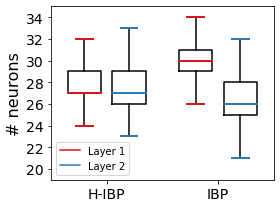

In [53]:
num_layers = 2
plt.figure(figsize=fig_size)
bpl = plt.boxplot([np.sum(np.asarray(np.squeeze(__Z_hibp[i] > 0.1)).astype(int), axis=1).reshape(-1) for i in range(num_layers)],
                  positions=[-0.4, 0.4], sym='', widths=0.6)
bpr = plt.boxplot([np.sum(np.asarray(np.squeeze(__Z_ibp[i] > 0.1)).astype(int), axis=1).reshape(-1) for i in range(num_layers)],
                  positions=[2. - 0.4, 2. + 0.4], sym='', widths=0.6)
set_box_pairs(bpl) # colors are from http://colorbrewer2.org/
set_box_pairs(bpr)

# draw temporary red and blue lines and use them to create a legend
hb, = plt.plot([], '#D7191C')
hr, = plt.plot([], '#2C7BB6')
plt.legend((hb, hr), ('Layer 1', 'Layer 2'), loc='lower left')
hb.set_visible(False)
hr.set_visible(False)

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
plt.xticks(range(0, len(ticks) * 2, 2), ticks, fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(-1, len(ticks)*2 - 1)
plt.ylim(19, 35)
plt.ylabel('# neurons', fontsize=legend_size)
#plt.xlabel('Layer', fontsize=label_size)
plt.tight_layout()
plt.savefig('plots/Zs_mnist_ibp_vs_hibp.pdf', bbox_inches='tight')
plt.show()

In [ ]:
np.squeeze(Z[0]).shape

In [ ]:
set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 22
label_size = 22
tick_size = 20
legend_size = 22
fig_size=(6, 5)

fig, ax = plt.subplots(1, 1, figsize=fig_size)

imgplot = ax.imshow(Z[0][0, :50,:60], cmap=plt.cm.Greys, vmin=0, vmax=1)
x_ticks = np.arange(0.0, 100, step=50)
plt.xticks(x_ticks, fontsize=tick_size)
plt.xlabel('$k$', fontsize=legend_size)
plt.yticks([], [])
#cbar_ax = fig.add_axes([0.95, 0.21, 0.05, 0.59])
#fig.colorbar(imgplot, cax=cbar_ax)
#cbar_ax.tick_params(labelsize=legend_size) 
plt.savefig('plots/hibp_weight_pruning_Z1.pdf', bbox_inches='tight')
fig.show()

In [ ]:
set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 22
label_size = 22
tick_size = 20
legend_size = 22

fig, ax = plt.subplots(1, 1, figsize=fig_size)

imgplot = ax.imshow(Z[1][0, :50,:60], cmap=plt.cm.Greys, vmin=0, vmax=1)
x_ticks = np.arange(0.0, 100, step=50)
plt.xticks(x_ticks, fontsize=tick_size)
plt.xlabel('$k$', fontsize=legend_size)
plt.yticks([], [])
cbar_ax = fig.add_axes([0.95, 0.13, 0.05, 0.75])
fig.colorbar(imgplot, cax=cbar_ax)
cbar_ax.tick_params(labelsize=legend_size) 
plt.savefig('plots/hibp_weight_pruning_Z2.pdf', bbox_inches='tight')
fig.show()

In [ ]:
set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 22
label_size = 22
tick_size = 20
legend_size = 22

# fig, ax = plt.subplots(1, 1)

# imgplot = ax.imshow(np.squeeze(Z[0])[:50,:100], cmap=plt.cm.Greys, vmin=0, vmax=1)
# x_ticks = np.arange(0.0, 100, step=50)
# plt.xticks(x_ticks, fontsize=tick_size)
# plt.xlabel('$k$', fontsize=legend_size)
# plt.yticks([], [])
# cbar_ax = fig.add_axes([0.95, 0.21, 0.05, 0.59])
# fig.colorbar(imgplot, cax=cbar_ax)
# cbar_ax.tick_params(labelsize=legend_size) 
# plt.savefig('plots/weight_pruning_Z.pdf', bbox_inches='tight')
# fig.show()

fig, ax = plt.subplots(2, 1, figsize=(4, 4))
for i in range(2):
    imgplot = ax[i].imshow(Z[i][0, :20, :60], cmap=plt.cm.Greys, vmin=0, vmax=1)
    ax[0].set_xticks(np.arange(0.0, 100, step=50))
    ax[0].set_xticklabels([], fontsize=tick_size)
    ax[i].set_yticks([], [])
    ax[i].set_yticklabels([], fontsize=tick_size)
    if i == 1:
        ax[i].set_xlabel('$k$', fontsize=legend_size)
        ax[i].set_xticklabels(np.arange(0, 100, step=50), fontsize=tick_size)
        ax[i].set_xticks(np.arange(0.0, 100, step=50))
        #ax[i].set_yticklabels([])
        cbar_ax = fig.add_axes([1.0, 0.22, 0.05, 0.69])
        fig.colorbar(imgplot, cax=cbar_ax, ticks = [0.0, 0.5, 1.0])
        cbar_ax.tick_params(labelsize=legend_size) 
        # Add colorbar, make sure to specify tick locations to match desired ticklabels
fig.tight_layout()
plt.savefig('plots/hibp_weight_pruning_Zs.pdf', bbox_inches='tight')
fig.show()

# IBP 

In [ ]:
# weight_pruning_runs5_ibp_l2_wp_n.pkl
with open('results/weight_pruning_ibp_new_xs.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

In [ ]:
xs_ibp = d['xs']
ya_ibp = d['ya_ibp']
yb_ibp = d['yb_ibp']

In [ ]:
# weight_pruning_runs5_ibp_l2_wp_n.pkl
with open('results/weight_pruning_hibp_new_xs.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

In [ ]:
xs_hibp = d['xs']
ya_hibp = d['ya_ibp']
yb_hibp = d['yb_ibp']

In [ ]:
_ibp_ya_mean = np.mean(ya_ibp, axis=0)
_ibp_ya_std = np.std(ya_ibp, axis=0)
_ibp_yb_mean = np.mean(yb_ibp, axis=0)
_ibp_yb_std = np.std(yb_ibp, axis=0)
_hibp_ya_mean = np.mean(ya_hibp, axis=0)
_hibp_ya_std = np.std(ya_hibp, axis=0)
_hibp_yb_mean = np.mean(yb_hibp, axis=0)
_hibp_yb_std = np.std(yb_hibp, axis=0)

def test_error(ls):
    return 100*(1-np.array(ls))

fig_size = (6, 5)

set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 22
tick_size = 20
legend_size = 22

fig, ax = plt.subplots(1, 1, figsize=fig_size)

ax.plot(xs_ibp, test_error(_ibp_ya_mean), linewidth=lw, color='b')
ax.fill_between(xs_ibp,
               test_error([x - y for x, y in zip(_ibp_ya_mean, _ibp_ya_std)]),
               test_error([x + y for x, y in zip(_ibp_ya_mean, _ibp_ya_std)]),
               alpha=0.2, color='b')

ax.plot(xs_ibp, test_error(_ibp_yb_mean), linewidth=lw, color='r')
ax.fill_between(xs_ibp,
               test_error([x - y for x, y in zip(_ibp_yb_mean, _ibp_yb_std)]),
               test_error([x + y for x, y in zip(_ibp_yb_mean, _ibp_yb_std)]),
               alpha=0.2, color='r')

ax.plot(xs_hibp, test_error(_hibp_ya_mean), linewidth=lw, color='g')
ax.fill_between(xs_hibp,
               test_error([x - y for x, y in zip(_hibp_ya_mean, _hibp_ya_std)]),
               test_error([x + y for x, y in zip(_hibp_ya_mean, _hibp_ya_std)]),
               alpha=0.2, color='g')

ax.plot(xs_hibp, test_error(_hibp_yb_mean), linewidth=lw, color='c')
ax.fill_between(xs_hibp,
               test_error([x - y for x, y in zip(_hibp_yb_mean, _hibp_yb_std)]),
               test_error([x + y for x, y in zip(_hibp_yb_mean, _hibp_yb_std)]),
               alpha=0.2, color='c')

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
plt.yticks(fontsize=tick_size)
x_ticks = np.arange(0.0, 1.5, step=0.02)
plt.xticks(x_ticks, fontsize=tick_size)
plt.ticklabel_format(axis='y', style='sci')
ax = fig.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
#ax.set_yticklabels([])
#plt.yscale('log')
#plt.legend(["IBP $|\mu|$", 'IBP snr'], fontsize=legend_size, loc='top left')
plt.legend(["IBP $|\mu|$", 'IBP snr',
           "H-IBP $|\mu|$", 'H-IBP snr',], fontsize=legend_size, loc='upper left')
plt.tight_layout()
plt.xlabel("Cut off", fontsize=legend_size)
plt.ylabel("Test error", fontsize=legend_size)
plt.xlim(0.9, 1.0)
plt.savefig("plots/weight_pruning_mnist_ibp_vs_hibp.pdf", bbox_inches='tight')
plt.show()

In [ ]:
hidden_size = [200, 200]
batch_size = 512
no_epochs = 100

tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
data_gen = MnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
task_id=0
    
tf.reset_default_graph()  
x_train, y_train, x_test, y_test = data_gen.task()
x_testsets.append(x_test)
y_testsets.append(y_test)

tag = 'ibp_l2_wp_n'
run = 0
name='ibp_wp_{0}_run{1}'.format(tag, run)

# Set the readout head to train
head = 0 if single_head else task_id
bsize = x_train.shape[0] if (batch_size is None) else batch_size

# Train network with maximum likelihood to initialize first model
if task_id == 0:
    ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
    ml_model.train(x_train, y_train, task_id, 100, bsize)
    mf_weights = ml_model.get_weights()
    mf_variances = None
    mf_betas = None
    ml_model.close_session()

# Train on non-coreset data
model = IBP_BNN(input_size=in_dim, 
                           hidden_size=hidden_size, 
                           output_size=out_dim, 
                           training_size=x_train.shape[0], 
                           no_pred_samples=100,
                           num_ibp_samples=10, prev_means=mf_weights, 
                           prev_log_variances=mf_variances, 
                           prev_betas=mf_betas,
                           learning_rate=0.001, learning_rate_decay=0.87,
                           prior_mean=0.0, prior_var=0.1,
                           alpha0=5.0, beta0=1.0,
                           lambda_1=1.0, lambda_2=1.0,
                           tensorboard_dir='logs_wp',
                           name=name,
                           use_local_reparam=True, implicit_beta=True)

model.create_model()
model.restore(model.log_folder)

Z_ibp = model.sess.run(model.Z, feed_dict={model.x: x_test, model.task_idx: task_id, model.training: False})

model.close_session()

In [ ]:
np.mean(np.squeeze(Z_ibp[0]), 1).shape

In [ ]:
##### Box plot params

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 16
tick_size = 14
legend_size = 16

num_layers = 2
ticks = ['H-IBP', 'IBP']
fig_size=(4, 3)

def set_box_pairs(bp):
    plt.setp(bp['boxes'], color='black', lw=1.5)
    plt.setp(bp['whiskers'], color='black', lw=1.5)
    
    
    plt.setp(bp['caps'][0], color='#D7191C', lw=2)
    plt.setp(bp['caps'][1], color='#D7191C', lw=2)
    plt.setp(bp['caps'][2], color='#2C7BB6', lw=2)
    plt.setp(bp['caps'][3], color='#2C7BB6', lw=2)
    plt.setp(bp['medians'][0], color='#D7191C', lw=2)
    plt.setp(bp['medians'][1], color='#2C7BB6', lw=2)

In [ ]:
num_layers = 2
plt.figure(figsize=fig_size)
bpl = plt.boxplot([np.sum(np.asarray(np.squeeze(Z[i] > 0.1)).astype(int), axis=1).reshape(-1) for i in range(num_layers)],
                  positions=[-0.4, 0.4], sym='', widths=0.6)
bpr = plt.boxplot([np.sum(np.asarray(np.squeeze(Z_ibp[i] > 0.1)).astype(int), axis=1).reshape(-1) for i in range(num_layers)],
                  positions=[2. - 0.4, 2. + 0.4], sym='', widths=0.6)
set_box_pairs(bpl) # colors are from http://colorbrewer2.org/
set_box_pairs(bpr)

# draw temporary red and blue lines and use them to create a legend
hb, = plt.plot([], '#D7191C')
hr, = plt.plot([], '#2C7BB6')
plt.legend((hb, hr), ('Layer 1', 'Layer 2'))
hb.set_visible(False)
hr.set_visible(False)

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
plt.xticks(range(0, len(ticks) * 2, 2), ticks, fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.xlim(-1, len(ticks)*2 - 1)
#plt.xlabel('Layer', fontsize=label_size)
plt.tight_layout()
plt.savefig('plots/Zs_mnist_ibp_vs_hibp.pdf', bbox_inches='tight')
plt.show()

# Sparse Variational Dropout

In [ ]:
# import pick file
with open('sparse_vd/weight_pruning_svd.pkl', 'rb') as input_file:
    d_svd = pickle.load(input_file)
d_svd.keys()

In [ ]:
with open('results/weight_pruning_hibp_new_xs.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

In [ ]:
svd_xs = d_svd['xs']
svd_ya_mean = np.mean(d_svd['ya'], axis=0)
svd_ya_std = np.std(d_svd['ya'], axis=0)
svd_yb_mean = np.mean(d_svd['yb'], axis=0)
svd_yb_std = np.std(d_svd['yb'], axis=0)
hibp_xs = d['xs']
hibp_ya_mean = np.mean(d['ya_ibp'], axis=0)
hibp_ya_std = np.std(d['ya_ibp'], axis=0)
hibp_yb_mean = np.mean(d['yb_ibp'], axis=0)
hibp_yb_std = np.std(d['yb_ibp'], axis=0)

def test_error(ls):
    return 100*(1-np.array(ls))

fig_size = (6, 5)

set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 22
tick_size = 20
legend_size = 22

fig, ax = plt.subplots(1, 1, figsize=fig_size)

ax.plot(hibp_xs, test_error(hibp_ya_mean), linewidth=lw, color='b')
ax.fill_between(hibp_xs,
               test_error([x - y for x, y in zip(hibp_ya_mean, hibp_ya_std)]),
               test_error([x + y for x, y in zip(hibp_ya_mean, hibp_ya_std)]),
               alpha=0.2, color='b')

ax.plot(hibp_xs, test_error(hibp_yb_mean), linewidth=lw, color='r')
ax.fill_between(hibp_xs,
               test_error([x - y for x, y in zip(hibp_yb_mean, hibp_yb_std)]),
               test_error([x + y for x, y in zip(hibp_yb_mean, hibp_yb_std)]),
               alpha=0.2, color='r')

ax.plot(svd_xs, test_error(svd_ya_mean), linewidth=lw, color='g')
ax.fill_between(svd_xs,
               test_error([x - y for x, y in zip(svd_ya_mean, svd_ya_std)]),
               test_error([x + y for x, y in zip(svd_ya_mean, svd_ya_std)]),
               alpha=0.2, color='g')

ax.plot(svd_xs, test_error(svd_yb_mean), linewidth=lw, color='c')
ax.fill_between(svd_xs,
               test_error([x - y for x, y in zip(svd_yb_mean, svd_yb_std)]),
               test_error([x + y for x, y in zip(svd_yb_mean, svd_yb_std)]),
               alpha=0.2, color='c')

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
plt.yticks(fontsize=tick_size)
x_ticks = np.arange(0.0, 1.5, step=0.02)
plt.xticks(x_ticks, fontsize=tick_size)
plt.ticklabel_format(axis='y', style='sci')
ax = fig.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
#ax.set_yticklabels([])
#plt.yscale('log')
#plt.legend(["IBP $|\mu|$", 'IBP snr'], fontsize=legend_size, loc='top left')
plt.legend(["H-IBP $|\mu|$", 'H-IBP snr',
           "SVD $|\mu|$", 'SVD snr',], fontsize=legend_size, loc='upper left')
plt.tight_layout()
plt.xlabel("Cut off", fontsize=legend_size)
plt.ylabel("Test error", fontsize=legend_size)
plt.xlim(0.9, 1.0)
plt.savefig("plots/weight_pruning_mnist_hibp_vs_svd.pdf", bbox_inches='tight')
plt.show()

# Local reparam + improved MFVI

In [ ]:
# weight_pruning_runs5_ibp_l2_wp_n.pkl
with open('results/weight_pruning_runs5_ibp_wp_lr_n.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

In [ ]:
xs_ibp = d['xs']
ya = d['ya_nnvi']
yb = d['yb_nnvi']
ya_ibp = d['ya_ibp']
yb_ibp = d['yb_ibp']

In [ ]:
xs_ibp.shape

In [ ]:
np.mean(ya[:,0]) # no pruning mfvi acc

In [ ]:
# weight_pruning_runs5_ibp_l2_wp_n.pkl
with open('results/weight_pruning_hibp_new_xs.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

In [ ]:
xs_hibp = d['xs']
ya_hibp = d['ya_ibp']
yb_hibp = d['yb_ibp']

In [ ]:
xs_hibp.shape

In [ ]:
ya_hibp.shape

In [ ]:
_hibp_ya_mean = np.mean(ya_hibp, axis=0)
_hibp_ya_std = np.std(ya_hibp, axis=0)
_hibp_yb_mean = np.mean(yb_hibp, axis=0)
_hibp_yb_std = np.std(yb_hibp, axis=0)
_ya_mean = np.mean(ya, axis=0)
_ya_std = np.std(ya, axis=0)
_yb_mean = np.mean(yb, axis=0)
_yb_std = np.std(yb, axis=0)

def test_error(ls):
    return 100*(1-np.array(ls))

fig_size = (6, 5)

set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 22
tick_size = 20
legend_size = 22

fig, ax = plt.subplots(1, 1, figsize=fig_size)

ax.plot(xs_ibp, test_error(_hibp_ya_mean), linewidth=lw, color='b')
ax.fill_between(xs_ibp,
               test_error([x - y for x, y in zip(_hibp_ya_mean, _hibp_ya_std)]),
               test_error([x + y for x, y in zip(_hibp_ya_mean, _hibp_ya_std)]),
               alpha=0.3, color='b')

ax.plot(xs_ibp, test_error(_hibp_yb_mean), linewidth=lw, color='g')
ax.fill_between(xs_ibp,
               test_error([x - y for x, y in zip(_hibp_yb_mean, _hibp_yb_std)]),
               test_error([x + y for x, y in zip(_hibp_yb_mean, _hibp_yb_std)]),
               alpha=0.3, color='g')

ax.plot(xs_ibp, test_error(_ya_mean), linewidth=lw, color='r')
ax.fill_between(xs_ibp,
               test_error([x - y for x, y in zip(_ya_mean, _ya_std)]),
               test_error([x + y for x, y in zip(_ya_mean, _ya_std)]),
               alpha=0.3, color='r')

ax.plot(xs_ibp, test_error(_yb_mean), linewidth=lw, color='c')
ax.fill_between(xs_ibp,
               test_error([x - y for x, y in zip(_yb_mean, _yb_std)]),
               test_error([x + y for x, y in zip(_yb_mean, _yb_std)]),
               alpha=0.3, color='c')

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
ax.set_xlim(0.0, 0.5)
plt.yticks(fontsize=tick_size)
x_ticks = np.arange(0.0, 1.5, step=0.1)
plt.xticks(x_ticks, fontsize=tick_size)
plt.ticklabel_format(axis='y')
ax = fig.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
#ax.set_yticklabels([])
#plt.yscale('log')
plt.legend(["H-IBP $|\mu|$", 'H-IBP snr', '$|\mu|$', 'snr'], fontsize=legend_size, loc='upper left')
plt.tight_layout()
plt.xlabel("Cut off", fontsize=legend_size)
plt.ylabel("Test error", fontsize=legend_size)
plt.xlim(0.6, 1.0)
plt.savefig("plots/weight_pruning_new_hibp_x5_better_mfvi.pdf", bbox_inches='tight')
plt.show()

In [ ]:
_ibp_ya_mean = np.mean(ya_ibp, axis=0)
_ibp_ya_std = np.std(ya_ibp, axis=0)
_ibp_yb_mean = np.mean(yb_ibp, axis=0)
_ibp_yb_std = np.std(yb_ibp, axis=0)
_hibp_ya_mean = np.mean(ya_hibp, axis=0)
_hibp_ya_std = np.std(ya_hibp, axis=0)
_hibp_yb_mean = np.mean(yb_hibp, axis=0)
_hibp_yb_std = np.std(yb_hibp, axis=0)

def test_error(ls):
    return 100*(1-np.array(ls))

fig_size = (6, 5)

set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 22
tick_size = 20
legend_size = 22

fig, ax = plt.subplots(1, 1, figsize=fig_size)

ax.plot(xs_ibp, test_error(_ibp_ya_mean), linewidth=lw, color='b')
ax.fill_between(xs_ibp,
               test_error([x - y for x, y in zip(_ibp_ya_mean, _ibp_ya_std)]),
               test_error([x + y for x, y in zip(_ibp_ya_mean, _ibp_ya_std)]),
               alpha=0.2, color='b')

ax.plot(xs_ibp, test_error(_ibp_yb_mean), linewidth=lw, color='r')
ax.fill_between(xs_ibp,
               test_error([x - y for x, y in zip(_ibp_yb_mean, _ibp_yb_std)]),
               test_error([x + y for x, y in zip(_ibp_yb_mean, _ibp_yb_std)]),
               alpha=0.2, color='r')

ax.plot(xs_ibp, test_error(_hibp_ya_mean), linewidth=lw, color='g')
ax.fill_between(xs_ibp,
               test_error([x - y for x, y in zip(_hibp_ya_mean, _hibp_ya_std)]),
               test_error([x + y for x, y in zip(_hibp_ya_mean, _hibp_ya_std)]),
               alpha=0.2, color='g')

ax.plot(xs_ibp, test_error(_hibp_yb_mean), linewidth=lw, color='c')
ax.fill_between(xs_ibp,
               test_error([x - y for x, y in zip(_hibp_yb_mean, _hibp_yb_std)]),
               test_error([x + y for x, y in zip(_hibp_yb_mean, _hibp_yb_std)]),
               alpha=0.2, color='c')

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
plt.yticks(fontsize=tick_size)
x_ticks = np.arange(0.0, 1.5, step=0.02)
plt.xticks(x_ticks, fontsize=tick_size)
plt.ticklabel_format(axis='y', style='sci')
ax = fig.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
#ax.set_yticklabels([])
#plt.yscale('log')
#plt.legend(["IBP $|\mu|$", 'IBP snr'], fontsize=legend_size, loc='top left')
plt.legend(["IBP $|\mu|$", 'IBP snr',
           "H-IBP $|\mu|$", 'H-IBP snr',], fontsize=legend_size, loc='upper left')
plt.tight_layout()
plt.xlabel("Cut off", fontsize=legend_size)
plt.ylabel("Test error", fontsize=legend_size)
plt.xlim(0.9, 1.0)
#plt.savefig("plots/weight_pruning_mnist_ibp_vs_hibp.pdf", bbox_inches='tight')
plt.show()